In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
import torchinfo
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime
import pickle



from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

# Select device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.xpu.is_available():
#   device = torch.device("xpu")
    


print("Device: {}".format(device))


# utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Device: cpu


/tmp/nix-shell.QdAhRF/ipykernel_47036/1274356740.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# my utils


#import data
#import data.datahandlers
#print(data.datahandlers)

#from pyutils.distdataset import DistDataset, SplitDataset
#from pyutils.lazynoisedataset import LazyNoiseDataset
import data.datahandlers as datahandlers


from data.datahandlers import LazyNoiseDataset, DistDataset, SplitDataset
from torch.utils.data import DataLoader
import pickle
import os


# loading dataset
cxr_imgs_dataset: DistDataset = None

# pickle!



dirname = os.getcwd()
cxr_imgs_pickle_dir = dirname + "/data/cheXpert/cxr_imgs_dataset.pickle"
print("[cxr_imgs pickle dir '{}']".format(cxr_imgs_pickle_dir))

if not os.path.isfile(cxr_imgs_pickle_dir):
    print("building new dataset - no pickle found")
    cxr_imgs_dataset = DistDataset( dirname + "/data/cheXpert/cxr_imgs{:03}.pt")
    
    with open(cxr_imgs_pickle_dir, "wb") as f:
        pickle.dump(cxr_imgs_dataset, f)
        print("  dumped pickle!" )



with open(cxr_imgs_pickle_dir, "rb") as f:
    print("loading pickle...")
    cxr_imgs_dataset = pickle.load(f)
    pass
#try: 
#    print("trying to unpickle dataset")
#    with open("data/cheXpert/cxr_imgs_dataset.pickle", "rb") as f:
#        cxr_imgs_dataset = pickle.load(f)
#except:
#    print("building new dataset - unpickling failed")
#    cxr_imgs_dataset = DistDataset("../cheXpert/cxp_cxrs{:03}.pt")
#
#    with open("data/cheXpert/cxr_imgs_dataset.pickle", "wb") as f:
#        pickle.dump(cxr_imgs_dataset, f)




noise_dataset = LazyNoiseDataset(cxr_imgs_dataset)
#noise_dataset = LazyNoiseDataset.from_distdataset_pickle("pyutils/pickles/cxrdataset.pickle")

print("noise dataset len: ", len(noise_dataset))

train_noise_dataset = SplitDataset(noise_dataset, split_end=100)
test_noise_dataset  = SplitDataset(noise_dataset, split_start=100, split_end=125)

print("  train noise dataset len: ", len(train_noise_dataset))
print("  test  noise dataset len: ", len(test_noise_dataset))



#train_noise_dataset = SplitDataset(noise_dataset, split_end=len(noise_dataset) * 0.8)
#test_noise_dataset  = SplitDataset(noise_dataset, split_start=len(noise_dataset) * 0.8)


train_noise_dataloader  = DataLoader(train_noise_dataset, batch_size=32, num_workers=2)
test_noise_dataloader   = DataLoader(test_noise_dataset, batch_size=32, num_workers=2)


[cxr_imgs pickle dir '/home/morris/Workspace/Python/xjobb/data/cheXpert/cxr_imgs_dataset.pickle']
loading pickle...
noise dataset len:  191027
  train noise dataset len:  100
  test  noise dataset len:  25


In [ ]:
from pyutils.myUNet import UNet

m = UNet()
m = m.to(device)
torchinfo.summary(m, (1,1,320,320))

/nix/store/zmim4ghaaa5zmnw8vxrvz4b768bz9sgy-python3-3.10.13-env/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 320, 320]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 320, 320]         --
│    │    └─Sequential: 3-1              [1, 64, 320, 320]         37,824
├─MaxPool2d: 1-2                         [1, 64, 160, 160]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 160, 160]        --
│    │    └─Sequential: 3-2              [1, 128, 160, 160]        221,952
├─MaxPool2d: 1-4                         [1, 128, 80, 80]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 80, 80]          --
│    │    └─Sequential: 3-3              [1, 256, 80, 80]          886,272
├─MaxPool2d: 1-6                         [1,

In [ ]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ).to(device)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1,
                               kernel_size=3, # unet uses 2?
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        ).to(device)


    def forward(self, x, residual=True):
        if residual:
            return self.forward_residual(x)
        else:
            return self.forward_non_residual(x)

    def forward_residual(self, x):
        x = x.to(device)
        r = x.clone()
        r = self.forward_non_residual(r)
        return x + r


    def forward_non_residual(self, x):
        x = x.to(device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#m = Autoencoder()
#m = m.to(device)
#torchinfo.summary(m, noise_dataset[0][0].shape)



  0%|          | 0/4 [00:00<?, ?it/s]

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


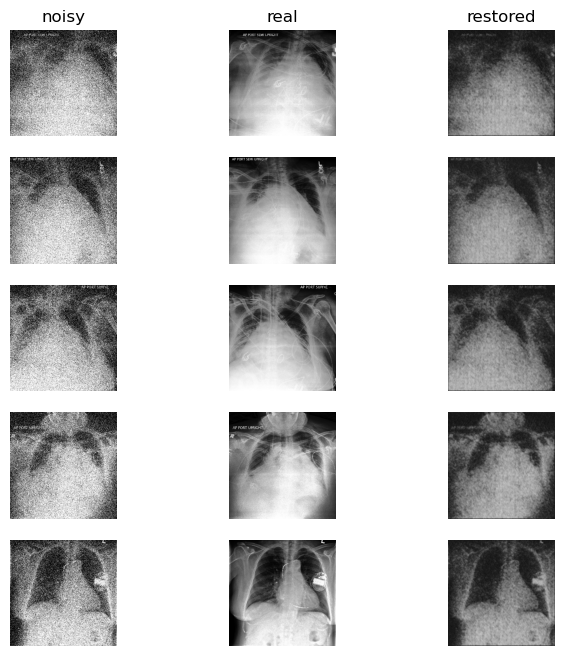


Epoch [1/10]
Loss - Train: 0.5585   Test: 0.3729
Time - since start: 337.4   this epoch: 299.9
(note: 'since start' does include total testing...)



  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Options
NUM_EPOCHS = 10
NUM_IMG_EXAMPLES = 5
NUM_TESTING_EPOCHS = 10 # in addition to last

# Time and logging
start_time = time.time()
last_epoch_time = time.time()# to be updated

training_loss_hist = []
testing_loss_hist = []
testing_epoch_is = []



# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)

# Train the autoencoder

for epoch in range(NUM_EPOCHS):
    m.train()

    progress_log = epoch % (NUM_EPOCHS / NUM_TESTING_EPOCHS) == 0 or epoch == NUM_EPOCHS - 1

    train_loss_acc = 0.0

    for x_batch, y_batch in tqdm(train_noise_dataloader):
        optimizer.zero_grad()
        output = m(x_batch)
        loss = criterion(y_batch.to(device), output)
        loss.backward()
        optimizer.step()
        train_loss_acc += loss.item()

    train_loss = train_loss_acc / len(train_noise_dataloader)
    training_loss_hist.append(train_loss)


    epoch_time = time.time() - last_epoch_time
    last_epoch_time = time.time()

    if progress_log:
        testing_epoch_is.append(epoch)
        m.eval()

        test_loss_acc = 0.0
        for x_test_batch, y_test_batch in test_noise_dataloader:
            output = m(x_test_batch.to(device))
            loss = criterion(y_test_batch.to(device), output)
            test_loss_acc += loss.item()

        test_loss = test_loss_acc / len(test_noise_dataloader)
        testing_loss_hist.append(test_loss)


        fig, axs = plt.subplots(NUM_IMG_EXAMPLES, 3, figsize=(8, 8))

        axs[0,0].set_title("noisy")
        axs[0,1].set_title("real")
        axs[0,2].set_title("restored")

        for i in range(NUM_IMG_EXAMPLES):
            print(type(test_noise_dataloader.dataset[i]))
            x, y = test_noise_dataloader.dataset[i]
            o = m(x.to(device))

            axs[i,0].set_axis_off()
            axs[i,1].set_axis_off()
            axs[i,2].set_axis_off()

            axs[i,0].imshow(x.cpu().squeeze(), cmap='gray')
            axs[i,1].imshow(y.cpu().squeeze(), cmap='gray')
            axs[i,2].imshow(o.cpu().detach().numpy().squeeze(), cmap='gray')

        plt.show()
        print(
"""
Epoch [{}/{}]
Loss - Train: {:.4f}   Test: {:.4f}
Time - since start: {:.1f}   this epoch: {:.1f}
(note: 'since start' does include total testing...)
""".format(epoch+1, NUM_EPOCHS, train_loss, test_loss, time.time() - start_time, epoch_time))


plt.plot( [i+1 for i in range(NUM_EPOCHS)], training_loss_hist, "b:o", label="Train Loss")
plt.plot([i+1 for i in testing_epoch_is], testing_loss_hist,  "r:o", label="Test Loss")
plt.title = "Loss over time"
plt.legend()
plt.show()


torch.save(m.state_dict(), "models/last_model")
torch.save(m.state_dict(), "models/all/[{}]-{}params".format(datetime.datetime.now().strftime("%d%b-%H.%M"), count_parameters(m)))




